# What are the population trends for Illinois counties?
#### Methodology
1. Extract, combine, and clean data
2. Calculate average percentages of new listings 
4. Scatter plot all counties over time 

### Import Libraries & Data

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import fredapi as fa
import seaborn as sns
from matplotlib.ticker import FuncFormatter

api_key = '4326c34340957958ddf39343ad409053'
fred = fa.Fred(api_key=api_key)
population_data = pd.read_csv(r'C:/Users/kevin/Documents/analysis_docs/Illinois_Housing_Affordability/csv_files/Counties.csv')


# Create an empty list to store DataFrames
population_dataframes = []

# Loop through county data and fetch data from FRED
for index, row in population_data.iterrows():
    county_name = row['county_name']
    county_id = row['population']

    try:
        population_data = fred.get_series(county_id)
        population_data = population_data.to_frame(name='population')  # Ensure data is in a DataFrame       
        population_data['county_name'] = county_name
        population_data['year'] = population_data.index.year
        mask = population_data['year'].apply(lambda x: x > 2015)
        filter_data = population_data[mask]
        population_dataframes.append(filter_data)
    except Exception as e:
        print(f"Error retrieving data for {county_name}: {e}")

# Combine DataFrames
combined_pop_df = pd.concat(population_dataframes)
combined_pop_df = combined_pop_df.reset_index()
combined_pop_df.rename(columns={'index': 'Date'}, inplace=True)


print(combined_pop_df)

          Date  population           county_name  year
0   2016-01-01      66.490      Adams County, IL  2016
1   2017-01-01      66.073      Adams County, IL  2017
2   2018-01-01      65.603      Adams County, IL  2018
3   2019-01-01      65.402      Adams County, IL  2019
4   2020-01-01      65.614      Adams County, IL  2020
..         ...         ...                   ...   ...
259 2019-01-01     282.465  Winnebago County, IL  2019
260 2020-01-01     284.916  Winnebago County, IL  2020
261 2021-01-01     283.333  Winnebago County, IL  2021
262 2022-01-01     281.542  Winnebago County, IL  2022
263 2023-01-01     280.922  Winnebago County, IL  2023

[264 rows x 4 columns]


## Calculate Population Mean For Top Least/Most Affordable Counties in Illinois

In [4]:
# Group by 'county_name' and calculate the mean of 'population'
population_per_county = combined_pop_df.groupby(['county_name', 'year'])['population'].mean()

# Define the counties you want to filter
target_pop_counties = ['Coles County, IL', 'Henry County, IL', 'Macoupin County, IL', 'Vermilion County, IL', 'Whiteside County, IL']
# Omit outlier Chicago from data
least_pop_counties = ['Du Page County, IL', 'Kane County, IL', 'Lake County, IL', 'Will County, IL']
# Filter the Series based on the first level of the index (county_name)
filtered_pop_series = population_per_county[population_per_county.index.get_level_values('county_name').isin(target_pop_counties)]
filtered_pop_df = filtered_pop_series.to_frame(name='population')
filtered_least = population_per_county[population_per_county.index.get_level_values('county_name').isin(least_pop_counties)]
filtered_least_df = filtered_least.to_frame(name='population')
# Calculate the mean of the entire group
mean_population = filtered_pop_df.groupby('year')['population'].mean()
mean_population = mean_population.to_frame(name='population')
mean_least = filtered_least_df.groupby('year')['population'].mean()
mean_least = mean_least.to_frame(name='population')

#### Normalize Values to Address Significant Differences Between Counties

In [5]:
def normalize(df):
  return (df - df['population'].min()) / (df['population'].max() - df['population'].min())

normalized_affordable = normalize(mean_population.copy())
normalized_least = normalize(mean_least.copy())

### Plot Normalized Population Trends

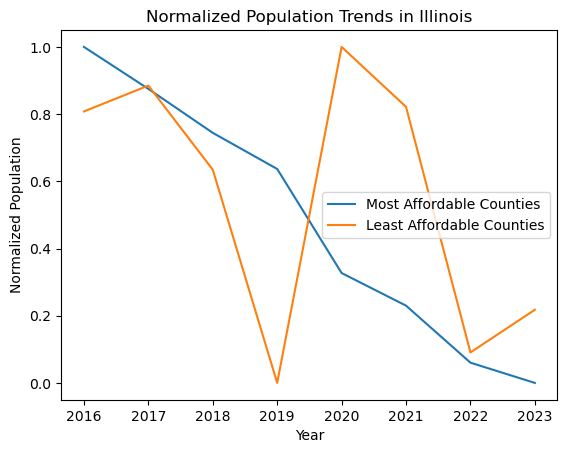

In [6]:
# Plot the normalized data
plt.plot(normalized_affordable['population'], label='Most Affordable Counties')
plt.plot(normalized_least['population'], label='Least Affordable Counties')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Normalized Population')
plt.title('Normalized Population Trends in Illinois')
plt.show()